# Ingestion

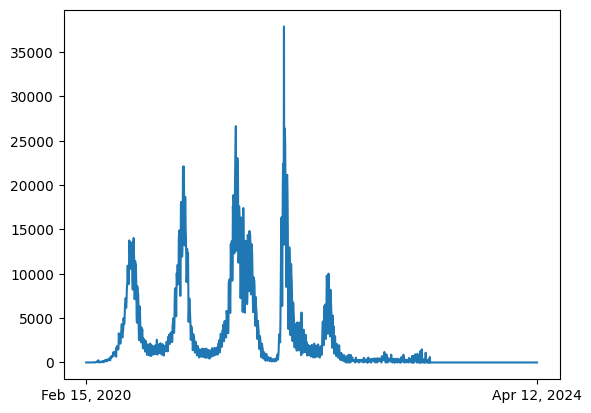

In [38]:
from bs4 import BeautifulSoup
import requests
import re
import json
import matplotlib.pyplot as plt
import pandas as pd

soup                = BeautifulSoup(requests.get("https://www.worldometers.info/coronavirus/country/south-africa/").content, "html.parser")
graph_cases_daily   = soup.find("script", string=lambda t: 'Highcharts' and 'graph-cases-daily' in t if t else False).get_text()
# Extraction of dates data
dates_regex = re.compile(r"xAxis:\s*{\s*categories:\s*(\[[^\]]+\])")
dates_matched = dates_regex.search(graph_cases_daily)
dates = json.loads(dates_matched.group(1)) if dates_matched else []

# Extraction of daily cases
daily_cases_pattern = re.compile(r"series:\s*\[\s*{[^}]*name:\s*'Daily Cases'[^}]*data:\s*(\[[^\]]+\])")
daily_cases_match = daily_cases_pattern.search(graph_cases_daily)

# Cleaning data

daily_cases_data = json.loads(daily_cases_match.group(1)) if daily_cases_match else []
daily_cases_data = [0 if case == None else case for case in daily_cases_data]

# Create a DataFrame from the two arrays
data = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'cases': daily_cases_data
})

# Set the 'date' column as the index
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

plt.plot(dates, daily_cases_data)
plt.xticks([0, len(dates) - 1], [dates[0], dates[-1]])
plt.show()

# Modelling

In [39]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller

print(data['cases'])
adf_test = adfuller(data['cases'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

date
2020-02-15    0
2020-02-16    0
2020-02-17    0
2020-02-18    0
2020-02-19    0
             ..
2024-04-08    0
2024-04-09    0
2024-04-10    0
2024-04-11    0
2024-04-12    0
Freq: D, Name: cases, Length: 1519, dtype: int64
ADF Statistic: -3.881124
p-value: 0.002178


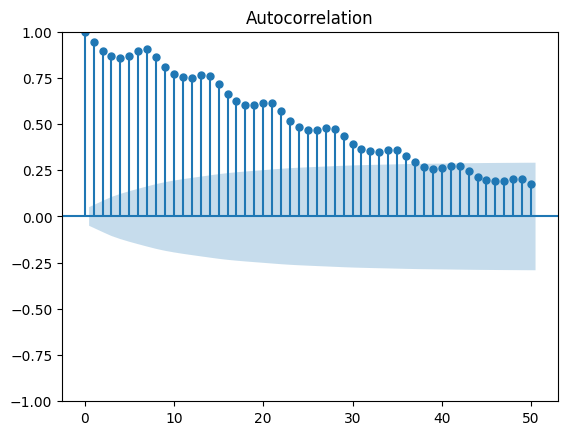

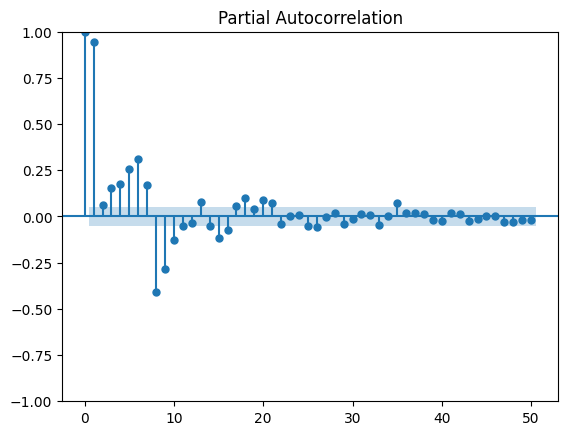

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Test for the differencing term
plot_acf(data['cases'], lags=50) 
plot_pacf(data['cases'], lags=50)
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error

# Split the data into train and test

run_date = pd.Timestamp('2023-01-01')
index_location = data.index.get_loc(run_date)

train_size = int(index_location + 1)
train = data[0:index_location]
print(train)

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['cases'], order=(1, 0, 7))
model_train_fit = model_train.fit()

# Forecast on the test dataset
forecast = model_train_fit.get_forecast(steps=7)
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create the desired list structure
forecast_list = {}

for date, mean in zip(predicted_mean.index, predicted_mean):
    forecast_list[date.strftime('%Y-%m-%d')] = {
            'predicted_mean': mean
    }
print(forecast_list)

# Rename the 'cases' key to 'predicted_mean' in each dictionary
train_copy = train.copy()
train_copy.index = train.index.strftime('%Y-%m-%d')
json.loads(train_copy.to_json(orient="index"))

            cases
date             
2020-02-15      0
2020-02-16      0
2020-02-17      0
2020-02-18      0
2020-02-19      0
...           ...
2022-12-27    154
2022-12-28    145
2022-12-29      0
2022-12-30    418
2022-12-31    204

[1051 rows x 1 columns]


AttributeError: 'PredictionResults' object has no attribute 'to_json'